# 用线性回归预测共享单车的需求

## 作业内容

在本次作业中，你将训练一个线性回归模型，预测未来的自行车租赁需求。

## 数据集介绍

本次使用的数据集来源于加利福尼亚大学欧文分校（UCI）大学的公开[数据集](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)，

关于本次数据集的各种信息可以参考该网站，同时也可以直接从该网站下载和使用数据集。不过这个共享单车数据集是固定桩形式，还是有别于我们常用的小蓝、小黄等单车，且数据集收集时间在2011-2012年,数据分为按日和按小时。

细节描述如下：

- instant：记录索引
- dteday：日期
- season：季节（1：春　2：夏　3：秋　4：冬）
- yr：年份（0：2011，1：2012）
- mnth：月份（1～12）
- hr：小时（0～23）
- holiday：是否是假期
- weekday：工作日
- workingday：如果既不是周末也不是假期则值为1，否则为0
- weathersit：
    1. 晴朗，云层很少，部分多云
    2. 薄雾+多云，薄雾+短暂云，薄雾+少云，薄雾
    3. 小雪，小雨+雷雨+散云，小雨+散云
    4. 大雨+冰粒+雷暴+薄雾，雪+雾
- temp：标准化温度（摄氏度）
    计算公式：(t-t_min)/(t_max-t_min), t_min = -8, t_max = +39（仅在小时范围内）
- atemp：标准化体表温度（摄氏度）
    计算公式：(t-t_min)/(t_max-t_min), t_min = -16, t_max = +50 (仅在小时范围内)
- hum：归一化湿度。值除以100（最大值）
- windspeed：归一化风速。值除以67（最大值）
- casual：临时用户数
- registered：注册用户数
- cnt：租赁自行车总数，包括临时用户和注册用户

对应的原始英文描述：

-   **instant:** Record index（记录号）
-   **dteday:** Date（日期）
-   **season:** Season (1:springer, 2:summer, 3:fall, 4:winter)（季节，分别为1234代替春夏秋冬）
-   **yr:** Year (0: 2011, 1:2012)（年份，用01代替2011和2012）
-   **mnth:** Month (1 to 12)（月份）
-   **hr:** Hour (0 to 23)（时间）
-   **holiday:** weather day is holiday or not (extracted from [Holiday Schedule](http://dchr.dc.gov/page/holiday-schedule))（是否为节假日）
-   **weekday:** Day of the week（对应星期几）
-   **workingday:** If day is neither weekend nor holiday is 1, otherwise is 0.（是否为工作日）
-   **weathersit:** (extracted from [Freemeteo](http://www.freemeteo.com))（天气）
-   1: Clear, Few clouds, Partly cloudy, Partly cloudy
-   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
-   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
-   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
-   **temp:** Normalized temperature in Celsius. The values are derived via (t-t*min)/(t*max-t*min), t*min=-8, t_max=+39 (only in hourly scale)（气温）
-   **atemp:** Normalized feeling temperature in Celsius. The values are derived via (t-t*min)/(t*max-t*min), t*min=-16, t_max=+50 (only in hourly scale)（体感温度）
-   **hum:** Normalized humidity. The values are divided to 100 (max)（湿度）
-   **windspeed:** Normalized wind speed. The values are divided to 67 (max)（风速）
-   **casual:** count of casual users（非注册用户个数）
-   **registered:** count of registered users（注册用户个数）
-   **cnt:** count of total rental bikes including both casual and registered（给定日期（天）总租车人数）

In [1]:
# 导入需要的包
import numpy as np
import pandas as pd

In [2]:
# 读取数据
dataset = pd.read_csv('bike-day.csv')
dataset = dataset.drop(['casual', 'registered'], axis=1)
# 去除了casual 和 registered 特征，因为这些特征无法帮助我们从单个用户的角度来模拟需求

Python Pandas库中的head()函数提供了查看数据集中前面几行的功能。

In [3]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


使用head()函数，我们会看到数据集中有日期格式、整数格式和浮点数格式的数据。另外，还能看到一些冗余的特征，如date（dteday）已经通过season、yr、mnth、hr等进行了分类。因此，数据集的dteday特征是可以抛弃不用的（虽然我们会暂时保留它以满足对数据集的探索需求）。

Pandas Python库中的 info() 函数也是查看数据集所包含的数据类型、数量和空值的好方法。

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  cnt         731 non-null    int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 80.1+ KB


### 问题1：对数据集进行划分
完成下列代码补全操作，具体的功能要求如下：
- 要求1：使用`train_test_split`对数据集进行划分。
- 要求2：测试集比例设置为33%
- 要求3：instant 和 dteday 不作为特征
- 要求4：cnt 为标签列

instant 和 dteday 不作为特征，使用drop()函数去除。

In [5]:
######## your code ########  
dataset =  dataset.drop(columns=['instant','dteday'], axis=1)
######## your code ########

用info()函数查看数据集是否去除instant 和 dteday特征。

In [6]:
dataset.info() # 正确显示如下

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  cnt         731 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.7 KB


使用 df.columns.values 查看表头。

In [7]:
dataset.columns.values

array(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype=object)

cnt 为标签列，其他均为特征，建立一个features的列表，去除 cnt 。

In [8]:
print(type(dataset.columns.values))

<class 'numpy.ndarray'>


In [9]:
######## your code ########
features = list(dataset.columns.values)[:-1]
label = list(dataset.columns.values)[-1:]
print(features)
print(label)
######## your code ########

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
['cnt']


In [10]:
features # 正确显示如下

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

train_test_split()函数基于用户指定的种子参数将原始数据集拆分为两个随机数据集，统一设置random_state种子参数为42。

提示设置test_size参数是测试集的比例，如果将它设置为0.3或30%，是讲数据集中70%的数据分配给了训练集，而剩余30%的数据分配给测试集。

In [11]:
from sklearn.model_selection import train_test_split

######## your code ########
X, X_test, y, y_test = train_test_split(dataset[features], dataset[label], test_size=0.33, random_state=42)
######## your code ########

查看训练集和测试集的 shape，参考结果如下

In [12]:
print('X(训练集特征) shape is {}'.format(X.shape))
print('y(训练集标签) shape is {}'.format(y.shape))
print('-'*30)
print('X(测试集特征) shape is {}'.format(X_test.shape))
print('y(测试集标签) shape is {}'.format(y_test.shape))

X(训练集特征) shape is (489, 11)
y(训练集标签) shape is (489, 1)
------------------------------
X(测试集特征) shape is (242, 11)
y(测试集标签) shape is (242, 1)


### 问题2：完成模型训练

完成下列代码补全操作，具体的功能要求如下：
- 要求1：初始化 sklearn 中线性回归模型为`reg`
- 要求2：使用训练集完成训练

In [13]:
from sklearn import datasets, linear_model, metrics

######## your code ########
# 初始化模型
model_lr = linear_model.LinearRegression()
######## your code ########

In [14]:
######## your code ########
# 训练模型
model_lr.fit(X=X, y=y)
######## your code ########

LinearRegression()

## 问题3：预测结果可视化

完成下列代码补全操作，具体的功能要求如下：
- 要求1：使用训练好的模型对测试集进行预测
- 要求2：使用matplotlib中合适的方法对模型预测值和测试集标签进行可视化。

In [17]:
######## your code ########
predictions = model_lr.predict(X=X_test)
######## your code ########

In [18]:
predictions.shape 

(242, 1)

flatten()函数用法<br>

flatten是numpy.ndarray.flatten的一个函数，即返回一个折叠成一维的数组。但是该函数只能适用于numpy对象，即array或者mat，普通的list列表是不行的。 

In [19]:
predictions.flatten() 

array([6163.72374286, 1415.99133209, 2914.36667772, 4357.08613924,
       6836.98912311, 7074.81266943,  711.91540046, 2105.60485775,
       7026.69042465, 6429.76926725, 2681.41479754, 2142.25187596,
       4243.3194979 , 5281.65764714, 2457.51205371, 2070.84343498,
       2460.27480445, 7328.15763577, 5582.75271189, 2818.48447822,
       7160.01738081, 8315.4959512 , 5122.05153718, 1277.77584192,
       1313.14130833, 4820.62685465, 1909.6289839 , 6765.93684522,
       3994.95016282, 5772.99554681, 3150.7660791 , 4120.62710397,
       6004.44595751, 6304.76896091, 5430.68181088, 4928.95211679,
       6749.64405998, 6078.38487303, 3066.21752298,  967.52699239,
       4100.92080805, 3882.38915766, 7164.7674337 , 3607.46139092,
       7214.30518166, 2134.69263742, 5241.34379345, 5084.09764328,
       6123.24461466, 4233.60045583, 3330.45819258, 2704.28344249,
       1845.33450428, 5786.60364063, 4882.32042342, 4242.28472974,
       3931.01652581, 2593.08364813, 3845.34364538, 6951.58818

pandas库的DataFrame属性中df.values的作用是返回numpy数组表示的数据

In [20]:
y_test.values

array([[6606],
       [1550],
       [3747],
       [6041],
       [7538],
       [7264],
       [1605],
       [2209],
       [7499],
       [5743],
       [1796],
       [3068],
       [4891],
       [5260],
       [2133],
       [2471],
       [2046],
       [8156],
       [5362],
       [2298],
       [7697],
       [5463],
       [5409],
       [1872],
       [1807],
       [5130],
       [2121],
       [7436],
       [3830],
       [5557],
       [2743],
       [3644],
       [6196],
       [7494],
       [5918],
       [3372],
       [7582],
       [6053],
       [2566],
       [1263],
       [3944],
       [3956],
       [7580],
       [4906],
       [6966],
       [ 705],
       [4458],
       [5298],
       [6043],
       [4996],
       [3351],
       [2431],
       [1011],
       [4475],
       [4725],
       [4727],
       [2395],
       [3351],
       [4788],
       [7175],
       [6153],
       [7442],
       [1471],
       [7865],
       [6530],
       [6211],
       [74

In [21]:
import matplotlib.pyplot as plt

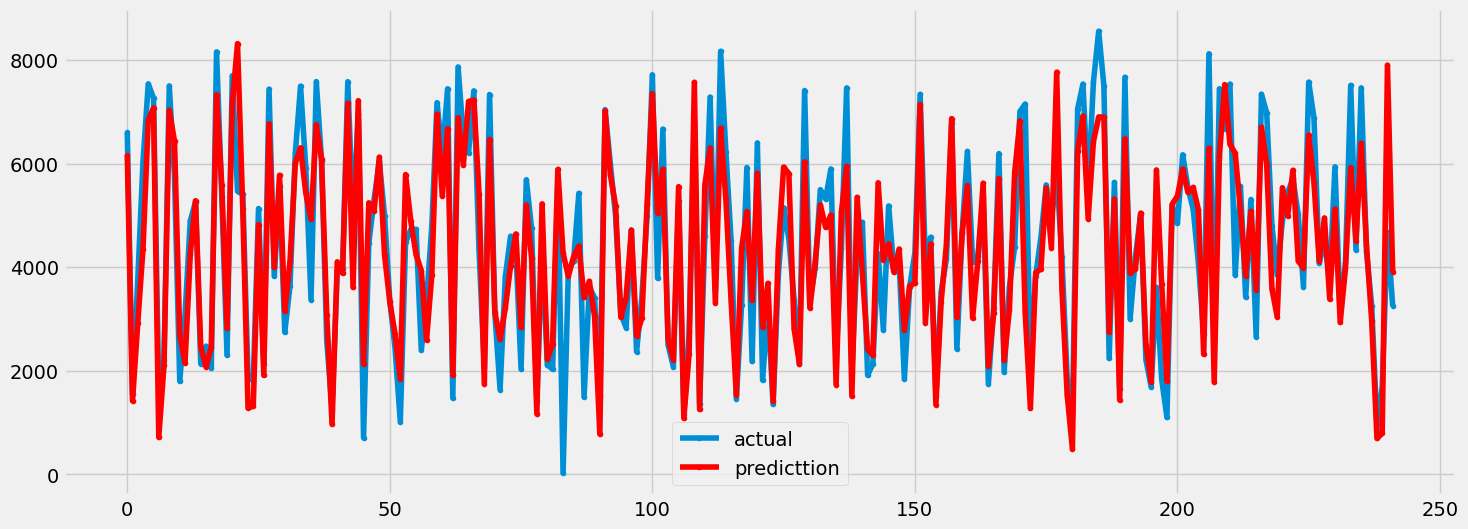

In [23]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(16,6))
 
# 测试集：真实值
######## your code ########
plt.plot(y_test.values, marker=".", label="actual")
######## your code ########

# 模型预测值
######## your code ########
plt.plot(predictions.flatten() , marker=".", label="predicttion", color="r")
######## your code ########

# 图例位置
plt.legend(loc="best")
plt.show()

## 问题4：使用评价函数计算精度

完成下列代码补全操作，具体的功能要求如下：
- 要求1：使用MAE计算测试集和与训练集预测精度。
- 要求2：使用MSE计算测试集和与训练集预测精度。

In [25]:
# 使用MAE计算测试集和与训练集预测精度
from sklearn.metrics import mean_absolute_error

######## your code ########
MAE_lr = mean_absolute_error(y_true=y_test, y_pred=predictions)
######## your code ########

In [28]:
# 使用MSE计算测试集和与训练集预测精度
from sklearn.metrics import mean_squared_error

######## your code ########
MSE_lr = mean_squared_error(y_true=y_test, y_pred=predictions)
######## your code ########

In [29]:
print('MAE_lr:{0}, MSE_lr:{1}'.format(MAE_lr, MSE_lr))

MAE_lr:642.8741142122183, MSE_lr:777068.4148123119
